In [1]:
import os
os.chdir('/ocean/projects/cis250019p/ikong/hw5')

import sys
import argparse
import numpy as np
import ruamel.yaml as yaml
import torch
import wandb
import logging
from logging import getLogger as get_logger
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from models import UNet, VAE, ClassEmbedder
from schedulers import DDPMScheduler, DDIMScheduler
from pipelines import DDPMPipeline
from utils import (
    seed_everything,
    init_distributed_device,
    is_primary,
    AverageMeter,
    str2bool,
    save_checkpoint,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [2]:
config = {
    "seed": 42,
    "device": device,
    
    "image_size": 128,
    "data_dir": "data",
    "subset": 0.01,
    "batch_size": 4,
    "num_workers": 4,
    "output_dir": "experiments",
    "run_name": "default",

    'use_cfg': False,

    "unet_in_size": 128,
    "unet_in_ch": 3,
    "unet_ch": 128,
    "unet_num_res_blocks": 2,
    "unet_ch_mult": [1, 2, 2, 4],
    "unet_attn": [2, 3],
    "unet_dropout": 0.0,

    "num_train_timesteps": 500,
    "num_inference_steps": 500,
    "beta_start": 0.0002,
    "beta_end": 0.02,
    "beta_schedule": "linear",
    "variance_type": "fixed_small",
    "prediction_type": "epsilon",
    "clip_sample": True,
    "clip_sample_range": 1.0,

    "learning_rate": 1e-5,
    "weight_decay": 1e-4,
    "num_epochs": 100,

    "grad_clip": 1.0,
}

In [3]:
seed_everything(config["seed"])

In [4]:
device = torch.device(config["device"])

# Load Image

In [5]:
transform = transforms.Compose(
        [
            transforms.Resize((config["image_size"], config["image_size"])),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            transforms.RandomHorizontalFlip(p=0.5),
        ]
    )

In [6]:
train_dataset = datasets.CIFAR10(
    config["data_dir"], train=True, transform=transform, download=True
)
subset_size = int(len(train_dataset) * config["subset"])
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_dataset = torch.utils.data.Subset(train_dataset, indices)

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=config["num_workers"],
    pin_memory=True,
    sampler=None,
    drop_last=True,
)

Image shape: torch.Size([4, 3, 128, 128])


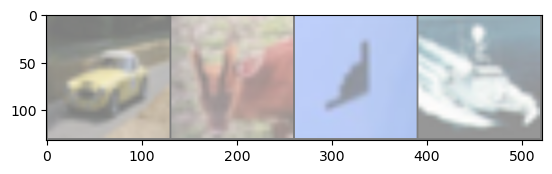

In [8]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
print("Image shape:", images.shape)

grid = make_grid(images, nrow=4, normalize=True)

grid = (grid + 1.0) / 2.0
grid = grid.clamp(0,1)
grid = grid.permute(1, 2, 0).cpu().numpy()

plt.imshow(grid)
plt.show()

In [9]:
total_batch_size = config["batch_size"] * 1

# Output Config

In [10]:
if not os.path.exists(config["output_dir"]):
    os.makedirs(config["output_dir"])

if config["run_name"] is None:
    config["run_name"] = f"exp-{len(os.listdir(config['output_dir']))}"
else:
    config["run_name"] = f"exp-{len(os.listdir(config['output_dir']))}-{config['run_name']}"
output_dir = os.path.join(config["output_dir"], config["run_name"])
save_dir = os.path.join(output_dir, "checkpoints")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

# Unet, DDPM Scheduler, Optimizer, LR Scheduler

### Unet

In [11]:
unet = UNet(
    input_size=config["unet_in_size"],
    input_ch=config["unet_in_ch"],
    T=config["num_train_timesteps"],
    ch=config["unet_ch"],
    ch_mult=config["unet_ch_mult"],
    attn=config["unet_attn"],
    num_res_blocks=config["unet_num_res_blocks"],
    dropout=config["unet_dropout"],
    conditional=config["use_cfg"],
    c_dim=config["unet_ch"],
)

In [12]:
num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params / 10 ** 6:.2f}M")

Number of parameters: 74.05M


In [13]:
unet = unet.to(device)

### Scheduler

In [14]:
scheduler = DDPMScheduler(
    num_train_timesteps=config["num_train_timesteps"],
    num_inference_steps=config["num_inference_steps"],
    beta_start=config["beta_start"],
    beta_end=config["beta_end"],
    beta_schedule=config["beta_schedule"],
    variance_type=config["variance_type"],
    prediction_type=config["prediction_type"],
    clip_sample=config["clip_sample"],
    clip_sample_range=config["clip_sample_range"],
)

In [15]:
scheduler = scheduler.to(device)

In [16]:
scheduler_wo_ddp = scheduler.to(device)

### Optimizer, LR Scheduler

In [17]:
optimizer = torch.optim.AdamW(
    unet.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"]
)
# TODO: setup scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config["num_epochs"] * len(train_loader), eta_min=1e-6
)

### Train Steps

In [18]:
num_update_steps_per_epoch = len(train_loader)
config["max_train_steps"] = config["num_epochs"] * num_update_steps_per_epoch

# Pipeline

In [19]:
pipeline = DDPMPipeline(unet=unet, scheduler=scheduler)

# Experiment

### Set up

In [20]:
print("***** Training arguments *****")
print("***** Running training *****")
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num Epochs = {config['num_epochs']}")
print(f"  Instantaneous batch size per device = {config['batch_size']}")
print(
    f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
)
print(
    f"  Total optimization steps per epoch {num_update_steps_per_epoch}"
)
print(f"  Total optimization steps = {config['max_train_steps']}")

progress_bar = tqdm(range(config["max_train_steps"]))


***** Training arguments *****
***** Running training *****
  Num examples = 500
  Num Epochs = 100
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Total optimization steps per epoch 125
  Total optimization steps = 12500


  0%|                                                                                  | 0/12500 [00:00<?, ?it/s]

### Start

In [21]:
# for epoch in range(config["num_epochs"]):
for epoch in range(5):
    loss_m = AverageMeter()

    unet.train()
    scheduler.train()

    for step, (images, labels) in enumerate(train_loader):
        batch_size = images.size(0)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        noise = torch.randn_like(images)

        timesteps = torch.randint(
            0, scheduler.num_train_timesteps, (batch_size,), device=images.device
        )

        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # # visualize image
        # grid = make_grid(images, nrow=4, normalize=True)
        # grid = (grid + 1.0) / 2.0
        # grid = grid.clamp(0,1)
        # grid = grid.permute(1, 2, 0).cpu().numpy()
        # plt.imshow(grid)
        # plt.title(f"Epoch {epoch}, Step {step}, Raw Image")
        # plt.show()

        # grid = make_grid(noisy_images, nrow=4, normalize=True)
        # grid = (grid + 1.0) / 2.0
        # grid = grid.clamp(0,1)
        # grid = grid.permute(1, 2, 0).cpu().numpy()
        # plt.imshow(grid)
        # plt.title(f"Epoch {epoch}, Step {step}, Noise Image")
        # plt.show()

        model_pred = unet(noisy_images, timesteps)

        if config["prediction_type"] == "epsilon":
            target = noise

        loss = F.mse_loss(model_pred, target)
        loss_m.update(loss.item())

        loss.backward()
        if config["grad_clip"]:
            torch.nn.utils.clip_grad_norm_(unet.parameters(), config["grad_clip"])
    
        param_before = next(unet.parameters()).clone()
        optimizer.step()
        param_after = next(unet.parameters()).clone()
        # print(f"Parameter change: {torch.sum(torch.abs(param_after - param_before)).item()}")

        lr_scheduler.step()

        progress_bar.update(1)

        if step % 100 == 0:
            print(
                f"Epoch {epoch+1}/{config['num_epochs']}, Step {step}/{num_update_steps_per_epoch}, Loss {loss.item()} ({loss_m.avg})"
            )
        # break

  0%|                                                                        | 2/12500 [00:00<1:15:09,  2.77it/s]

Epoch 1/100, Step 0/125, Loss 0.999896764755249 (0.999896764755249)


  1%|▌                                                                       | 102/12500 [00:17<33:56,  6.09it/s]

Epoch 1/100, Step 100/125, Loss 0.9409116506576538 (0.9777463928307637)


  1%|▋                                                                       | 127/12500 [00:21<36:00,  5.73it/s]

Epoch 2/100, Step 0/125, Loss 0.9203876256942749 (0.9203876256942749)


  2%|█▎                                                                      | 227/12500 [00:37<33:50,  6.04it/s]

Epoch 2/100, Step 100/125, Loss 0.8398670554161072 (0.8789294208630477)


  2%|█▍                                                                      | 252/12500 [00:42<35:53,  5.69it/s]

Epoch 3/100, Step 0/125, Loss 0.8138205409049988 (0.8138205409049988)


  3%|██                                                                      | 352/12500 [00:58<33:24,  6.06it/s]

Epoch 3/100, Step 100/125, Loss 0.7298436164855957 (0.7720844822354836)


  3%|██▏                                                                     | 377/12500 [01:02<36:05,  5.60it/s]

Epoch 4/100, Step 0/125, Loss 0.7098851203918457 (0.7098851203918457)


  4%|██▋                                                                     | 477/12500 [01:19<32:54,  6.09it/s]

Epoch 4/100, Step 100/125, Loss 0.625866174697876 (0.6656316701728519)


  4%|██▉                                                                     | 502/12500 [01:23<35:06,  5.70it/s]

Epoch 5/100, Step 0/125, Loss 0.6040474772453308 (0.6040474772453308)


  5%|███▍                                                                    | 602/12500 [01:39<32:46,  6.05it/s]

Epoch 5/100, Step 100/125, Loss 0.5242564082145691 (0.5660791627251276)


  5%|███▌                                                                    | 625/12500 [01:43<32:47,  6.04it/s]

In [23]:
unet.eval()
generator = torch.Generator(device=device)
generator.manual_seed(epoch + config["seed"])

gen_images = pipeline(
    batch_size=config["batch_size"],
    num_inference_steps=config["num_inference_steps"],
    generator=generator,
    device=device,
)

100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.15it/s]


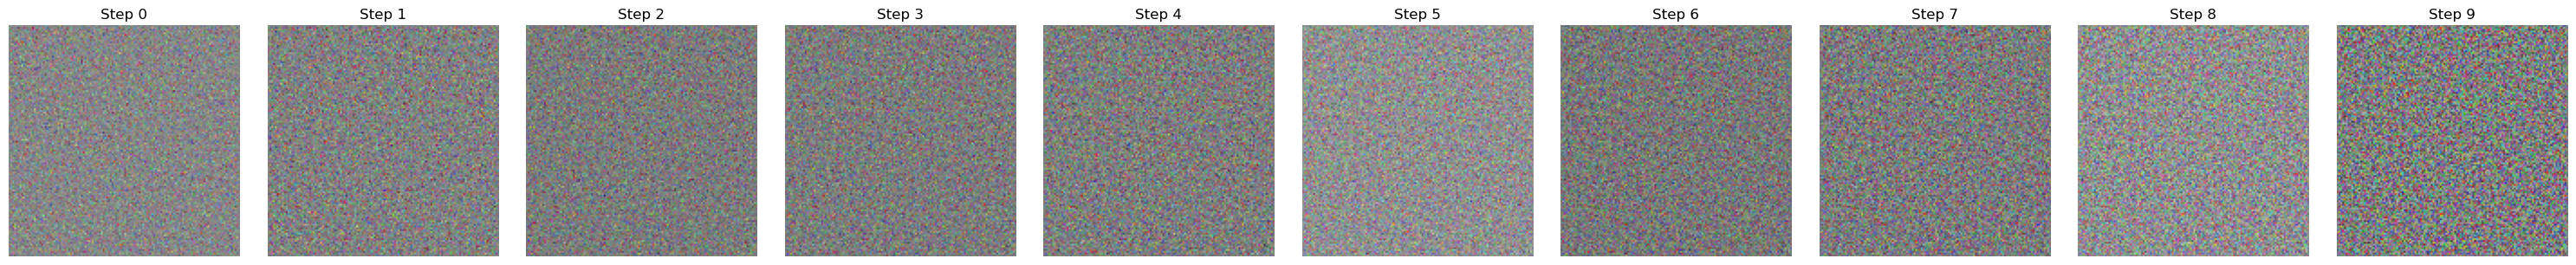

In [ ]:
# fig, axes = plt.subplots(1, len(debug_images), figsize=(len(debug_images)*3, 3))
# for i, img in enumerate(debug_images):
#     # Convert to numpy and normalize to [0, 1]
#     img_vis = img[0]
#     img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())
#     img_vis = img_vis.permute(1, 2, 0).cpu().numpy()
#     img_vis = np.clip(img_vis, 0, 1)
    
#     if len(debug_images) > 1:
#         axes[i].imshow(img_vis)
#         axes[i].set_title(f"Step {i}")
#         axes[i].axis("off")
#     else:
#         axes.imshow(img_vis)
#         axes.set_title("Single step")
#         axes.axis("off")

# plt.tight_layout()

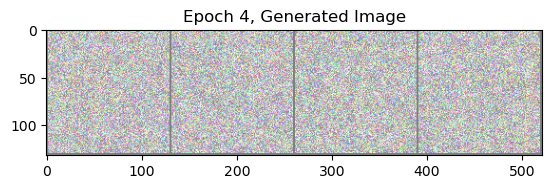

In [24]:
# Convert PIL images to tensors
gen_images_tensors = [transforms.ToTensor()(img) for img in gen_images]

# Create a grid of images
grid = make_grid(gen_images_tensors, nrow=4, normalize=True)

# Convert the grid to a format suitable for display
grid = (grid + 1.0) / 2.0
grid = grid.clamp(0, 1)
grid = grid.permute(1, 2, 0).cpu().numpy()

# Display the grid
plt.imshow(grid)
plt.title(f"Epoch {epoch}, Generated Image")
plt.show()